
## Library Import

In [1]:
# default
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset 
from torch.utils import data as data

# torchvision
from torchvision.models import vgg16
from torchvision.ops import RoIPool
from torchvision.ops import nms

# image load
import cv2
from PIL import Image

# augumentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# util
from pathlib import Path # Path 객체
from pycocotools.coco import COCO # COCO형식 JSON 파일 손쉽게 읽기
from torchsummary import summary # model summary

## Hyper Parameters Set

In [2]:
data_dir = Path('../../detection/dataset')
annotation = data_dir / 'train.json'

## 0. Util

In [3]:
def loc2bbox(src_bbox, loc): # (22500, 4)
    """
    from src_bbox to dst bbox using loc
    Args:
        src_bbox: 소스 바운딩 박스
        loc: 델타(미세 조정값)
    Returns: dst_bbox
    """

    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    # y_min, x_min, y_max, x_max
    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0:1]
    dx = loc[:, 1:2]
    dh = loc[:, 2:3]
    dw = loc[:, 3:4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox2loc(src_bbox, dst_bbox):
    """
    src_bbox : 예측된 좌표값(or anchor), dst_bbox: gt 좌표값 -> loc(y, x, h, w)
    """

    # x_min, y_min, x_max, y_max
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    # x_min, y_min, x_max, y_max
    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc


def normal_init(m, mean, stddev, truncated=False):
    """
    weight initialization
    """
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean) 
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


def get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) &
        (anchor[:, 1] >= 0) &
        (anchor[:, 2] <= H) &
        (anchor[:, 3] <= W)
    )[0]
    return index_inside


def unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of size count)
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret


## util ##
def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()

def totensor(data, cuda = True):
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    if isinstance(data, torch.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor

def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, torch.Tensor):
        return data.item()

## 1. Dataset

In [4]:
class CustomDataset(Dataset):
    def __init__(self, annotation, data_dir, transforms):
        super().__init__()
        self.data_dir = data_dir
        self.coco = COCO(annotation) # Experiment 1-1
        self.transforms = transforms 
        
    def __getitem__(self, index):
        # 이미지 정보 불러오기
        image_id = self.coco.getImgIds(imgIds=index)
        image_info = self.coco.loadImgs(image_id)[0]

        # 이미지 로드 
        # Experiment 1-2
        image = cv2.imread(str(Path(self.data_dir) / image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # 어노테이션 정보 로드 
        # Experiment 1-3
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # 박스 가져오기
        boxes = np.array([x['bbox'] for x in anns])

        #-- x, y, w, h -> x1, y1, x2, y2(coco -> pascal_voc)
        # ❤ 애를 해줘야하는 이유를 모르겠음 애초에 transform을 coco로 하면 되는 거 아닌가?
        # boxes (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # 레이블 가져오기
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # transform
        # Experiment 1-4
        sample = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }
        sample = self.transforms(**sample)
        image = sample['image']
        bboxes = torch.tensor(sample['bboxes'], dtype=torch.float32)
        boxes = torch.tensor(sample['bboxes'], dtype=torch.float32)

        # ❤  이후 계산의 편의를 위해서 한다. 무슨 상황?
        # bboxes (x_min, y_min, x_max, y_max) -> boxes (y_min, x_min, y_max, x_max)
        boxes[:, 0] = bboxes[:, 1]
        boxes[:, 1] = bboxes[:, 0]
        boxes[:, 2] = bboxes[:, 3]
        boxes[:, 3] = bboxes[:, 2]

        return image, boxes, labels
        # return image, boxes, labels, scale
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

## 2. Transform

In [5]:
# Train dataset transform
def get_train_transform():
    return A.Compose([
        A.Resize(height = 512, width = 512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# No transform
def no_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # format for pytorch tensor
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## 3. RPN(Region Proposal Network)

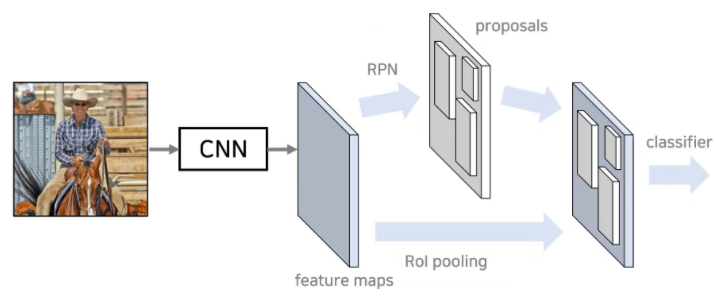

### 3-1) Backborn 정의

In [6]:
vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
summary(vgg16().cuda(), input_size=(3, 800, 800), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 800, 800]           1,792
              ReLU-2         [16, 64, 800, 800]               0
            Conv2d-3         [16, 64, 800, 800]          36,928
              ReLU-4         [16, 64, 800, 800]               0
         MaxPool2d-5         [16, 64, 400, 400]               0
            Conv2d-6        [16, 128, 400, 400]          73,856
              ReLU-7        [16, 128, 400, 400]               0
            Conv2d-8        [16, 128, 400, 400]         147,584
              ReLU-9        [16, 128, 400, 400]               0
        MaxPool2d-10        [16, 128, 200, 200]               0
           Conv2d-11        [16, 256, 200, 200]         295,168
             ReLU-12        [16, 256, 200, 200]               0
           Conv2d-13        [16, 256, 200, 200]         590,080
             ReLU-14        [16, 256, 2

In [8]:
def decom_vgg16(pretrained: bool):
    # the 30th layer of features is relu of conv5_3
    model = vgg16(pretrained=pretrained)
    
    features = list(model.features)[:30] # max_poll 제외
    classifier = model.classifier

    classifier = list(classifier)
    del classifier[6]
    if not use_drop:
        del classifier[5]
        del classifier[2]
    classifier = nn.Sequential(*classifier)

    # freeze top4 conv
    for layer in features[:10]:
        for p in layer.parameters():
            p.requires_grad = False

    return nn.Sequential(*features), classifier

### 3-2) Anchor box 생성

In [9]:
def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    """ 
    원본 이미지 기준 base_size = 16
    한 픽셀당 몇개의 anchor box가 생성 되나?
    하나의 픽셀에 대해서 위치 정보 없이 크기만 return
    Args:
        ratios: 비율
        anchor_scales: 스케일
    Returns: basic anchor boxes, shape=(R, 4)
        R: len(ratio) * len(anchor_scales) = anchor 개수 = 9
        4: anchor box 좌표 값
    """
    
    py = base_size / 2. # center y
    px = base_size / 2. # center x

    # (9 x 4)
    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32) # 빈 achor box anchor_box
    
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            
            # HW = S^2 라고 정의햇음 논문해서
            # H = rW 라고 정의했음 논문에서
            # rW^2 = S^2
            # W^2 = S^2 / r
            # w = s * sqrt(1/ r)
            
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])       # height
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])  # width

            index = i * len(anchor_scales) + j
            
            # offset of anchor box
            anchor_base[index, 0] =  py - h / 2 # y_min
            anchor_base[index, 1] =  px - w / 2 # x_min
            anchor_base[index, 2] =  py + h / 2 # y_max
            anchor_base[index, 3] =  px + w / 2 # x_max
            
    return anchor_base # (9,4)

### 3-3) Region proposal network

VGG16 통과한 feature map으로부터 region proposal들 생성

In [27]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32], feat_stride=16, proposal_creator_params=dict(),):
        """ 
        vgg를 통과한 feature map에서 각각 anchor box 생성
        각 anchor box별로 score를 계산해야한다.
        base anchor box의 위치를 어느만큼 바꿀지 미세조정해야한다.
        
        Args:
            ratios: 비율
            anchor_scales: 스케일
        Returns: 
        """
        super(RegionProposalNetwork, self).__init__()

        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios) # 9개의 anchorbox 생성 (9 x 4)
        self.feat_stride = feat_stride # ❤  
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params) # proposal_creator_params : 해당 네트워크가 training인지 testing인지 알려준다.
        n_anchor = self.anchor_base.shape[0] # anchor 개수 - 9
        self.conv1 = nn.Conv2d(in_chaneels=in_channels, out_channels=mid_channels, kernel_size=3, stride=1, padding=1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)  # 9*2 (anchor box 수 x 2(object true, false))
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)   # 9*4 (anchor box 수 x (x, y, w, h) 조절 값)
        
        # 0. util에 정의 초기화하는거
        normal_init(self.conv1, 0, 0.01) # weight initalizer
        normal_init(self.score, 0, 0.01) # weight initalizer
        normal_init(self.loc, 0, 0.01)   # weight initalizer

    def forward(self, x, img_size, scale=1.):
        # img_size = 원본이미지 크기
        # x(=feature map) : torch.Size([n, 512, 50, 50])
        n, _, hh, ww = x.shape

        # 전체 (h*w*9)개 anchor의 좌표값 # anchor_base:(9, 4)
        anchor = self._enumerate_shifted_anchor(self.anchor_base, self.feat_stride, hh, ww) # # torch.size([22500, 4])
        # anchor = self._enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, hh, ww) 
        n_anchor = self.anchor_base.shape[0]
        
        # middle 한번 layer 통과
        middle = F.relu(self.conv1(x)) # torch.size([n, 512, 50, 50]) -> torch.Size([n, 512, 50, 50])
        
        # predicted bounding box offset
        rpn_locs = self.loc(middle) # bounding_box 보정 torch.Size([n, 512, 50, 50])-> torch.size([n, 36, 50, 50])
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4) # torch.size([n, 22500, 4]) # anchor랑 맞춰줌

        # predicted scores for anchor (foreground or background)
        rpn_scores = self.score(middle)  # torch.Size([n, 512, 50, 50]) -> torch.size([n, 18, 50, 50])
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous() # torch.size([n, 50, 50, 18])
        
        # scores for foreground
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4) # score로 softmax torch.size([n, 50, 50, 9, 2])
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous() # torch.size([n, 50, 50, 9]) # object가 존재하는거 가져옴
        rpn_fg_scores = rpn_fg_scores.view(n, -1) # torch.size([n, 22500])
        
        rpn_scores = rpn_scores.view(n, -1, 2) # torch.size([n, 50, 50, 18]) -> torch.size([n, 22500, 2]) # anchor랑 맞춰줌

        # proposal생성 (ProposalCreator)
        # 22500 -> 2000개 뽑자
        rois = list()        # proposal의 좌표값이 있는 bounding box array
        roi_indices = list() # roi에 해당하는 image 인덱스
        for i in range(n):
            # (22500, 4) loc 정보, (22500,)의  fg score, (22500, 4) anchore box, 원본이미지 크기, scale 값 = 1
            # return (2000, 4)
            roi = self.proposal_layer(rpn_locs[i].cpu().data.numpy(),rpn_fg_scores[i].cpu().data.numpy(), anchor, img_size, scale=scale)
            
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)
        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        
        return rpn_locs, rpn_scores, rois, roi_indices, anchor


    def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
        # -- 원본이미지 기준
        
        # anchor_base는 하나의 pixel에 9개 종류의 anchor box를 나타냄
        # 이것을 enumerate시켜 전체 이미지의 pixel에 각각 9개의 anchor box를 가지게 함
        # 32x32 feature map에서는 32x32x9=9216개 anchor box가짐

        shift_y = np.arange(0, height * feat_stride, feat_stride) # (1 x height)
        shift_x = np.arange(0, width * feat_stride, feat_stride) # (1 x width)
        shift_x, shift_y = np.meshgrid(shift_x, shift_y) # (width, height)
        shift = np.stack((shift_y.ravel(), shift_x.ravel(),
                          shift_y.ravel(), shift_x.ravel()), axis=1) # ((width x height), 4)

        A = anchor_base.shape[0] # anchor 수
        K = shift.shape[0] # 총 pixel 수
        
        # ❤ 
        anchor = anchor_base.reshape((1, A, 4)) + \
                 shift.reshape((1, K, 4)).transpose((1, 0, 2))
        anchor = anchor.reshape((K * A, 4)).astype(np.float32)
        return anchor # (22500, 4) -> (anchor box 수, (y1, x1, y2, x2))


In [11]:
x = np.arange(0, 10, 2)
y = np.arange(0, 10, 2)

mx, my = np.meshgrid(x, y)
print(mx)
print(my)
result = np.stack((my.ravel(), mx.ravel(),
                          my.ravel(), mx.ravel()), axis=1)
result

[[0 2 4 6 8]
 [0 2 4 6 8]
 [0 2 4 6 8]
 [0 2 4 6 8]
 [0 2 4 6 8]]
[[0 0 0 0 0]
 [2 2 2 2 2]
 [4 4 4 4 4]
 [6 6 6 6 6]
 [8 8 8 8 8]]


array([[0, 0, 0, 0],
       [0, 2, 0, 2],
       [0, 4, 0, 4],
       [0, 6, 0, 6],
       [0, 8, 0, 8],
       [2, 0, 2, 0],
       [2, 2, 2, 2],
       [2, 4, 2, 4],
       [2, 6, 2, 6],
       [2, 8, 2, 8],
       [4, 0, 4, 0],
       [4, 2, 4, 2],
       [4, 4, 4, 4],
       [4, 6, 4, 6],
       [4, 8, 4, 8],
       [6, 0, 6, 0],
       [6, 2, 6, 2],
       [6, 4, 6, 4],
       [6, 6, 6, 6],
       [6, 8, 6, 8],
       [8, 0, 8, 0],
       [8, 2, 8, 2],
       [8, 4, 8, 4],
       [8, 6, 8, 6],
       [8, 8, 8, 8]])

### 3-4) Proposal 생성

RPN에서 구한 rpn_loc와 anchor을 통해서 Region of Interest(RoI)를 생성  
RoI 개수 줄이기 위해서 미리 정해둔 크기(min_size)에 맞는 roi들 중 NMS를 통해 최종 RoI 반환 (train 시 2000개)

In [12]:
class ProposalCreator:
    """
    RPN의 class prediction(score)정보와 box prediction(조정) 정보를 이용해서 fast rcnn에 넘길 roi를 넘겨준다.
    """
    def __init__(self, parent_model,
                 nms_thresh=0.7, # nms threshold
                 n_train_pre_nms=12000, # train시 nms 전 roi 개수 - score로 우선 이정도 필터한다.
                 n_train_post_nms=2000, # train시 nms 후 roi 개수 - nms를 거치고 한번더 필터
                 n_test_pre_nms=6000,   # test시 nms 전 roi 개수
                 n_test_post_nms=300,   # test시 nms 후 roi 개수
                 min_size=16            
                 ):
        self.parent_model = parent_model # 해당 모델이 train중인지 test중인지 나타냄
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size # 최소 bboxes 크기

    def __call__(self, loc, score, anchor, img_size, scale=1.):   
        # (22500, 4) loc 정보, (22500,)의  fg score, (22500, 4) anchore box, 원본이미지 크기, scale 값 = 1
        if self.parent_model.training: # train중일 때
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else: # test중일 때
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        # anchor의 좌표값과 predicted bounding bounding box offset(y,x,h,w)를 통해 bounding box 좌표값(y_min, x_min, y_max, x_max) 생성
        roi = loc2bbox(anchor, loc) # (22500, 4), (22500, 4) -> (22500, 4)

        # img_size인 이유 feet_stride랑 연관
        # Clip predicted boxes to image.
        roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
        roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])

        # min_size 보다 작은 box들은 제거
        min_size = self.min_size * scale
        hs = roi[:, 2] - roi[:, 0]
        ws = roi[:, 3] - roi[:, 1]
        
        # 22500 -> 22500 > ?(18000)
        keep = np.where((hs >= min_size) & (ws >= min_size))[0]
        roi = roi[keep, :] # (18000, 4)
        score = score[keep] # (18000,)
        
        # Sort all (proposal, score) pairs by score from highest to lowest.
        # Take top pre_nms_topN 
        order = score.ravel().argsort()[::-1] # 내림차순 정렬 index를 정보
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :] # (12000, 4)
        score = score[order] # (12000,)

        # nms 적용 # (x<12000,) index 
        keep = nms(
            torch.from_numpy(roi).cuda(),
            torch.from_numpy(score).cuda(),
            self.nms_thresh)
        
        if n_post_nms > 0:
            keep = keep[:n_post_nms]
        roi = roi[keep.cpu().numpy()] # (2000, 4)
        
        # 최종적으로 2천개만 사용한다.
        return roi 

## 4. Faster R-CNN Head 정의

RPN에서 나온 2000개 RoI로 부터 RoI pool을 한 후에 classifier, regressor 통과

In [ ]:
class VGG16RoIHead(nn.Module):
    """
    Faster R-CNN head
    RoI pool 후에 classifier, regressior 통과
    """

    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier  
        self.cls_loc = nn.Linear(4096, n_class * 4) # bounding box regressor
        self.score = nn.Linear(4096, n_class) # Classifier

        normal_init(self.cls_loc, 0, 0.001)  # weight initialize
        normal_init(self.score, 0, 0.01)     # weight initialize

        self.n_class = n_class # 배경 포함한 class 수
        self.roi_size = roi_size # RoI-pooling 후 feature map의  높이, 너비
        self.spatial_scale = spatial_scale # roi resize scale
        self.roi = RoIPool( (self.roi_size, self.roi_size),self.spatial_scale)

    def forward(self, x, rois, roi_indices):
        # in case roi_indices is  ndarray
        roi_indices = totensor(roi_indices).float()
        rois = totensor(rois).float()
        indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
        # NOTE: important: yx->xy
        xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
        indices_and_rois =  xy_indices_and_rois.contiguous() 

        # 각 이미지 roi pooling 
        pool = self.roi(x, indices_and_rois) 
        # flatten 
        pool = pool.view(pool.size(0), -1)
        # fully connected
        fc7 = self.classifier(pool)
        # regression 
        roi_cls_locs = self.cls_loc(fc7)
        # softmax
        roi_scores = self.score(fc7)
        
        return roi_cls_locs, roi_scores

## Experiment 1

1) pycocotools.coco

pycocotools.coco에서 json경로를 넣어주면 한번에 load된다.

In [13]:
coco = COCO(annotation)
print()
print(f'coco data size{len(coco.getImgIds())}')

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!

coco data size4883


In [14]:
image_id = coco.getImgIds(imgIds=1)

In [15]:
image_info = coco.loadImgs(image_id)[0]

2)  Image load

In [16]:
image_path = data_dir / image_info['file_name']
image_path

PosixPath('../../detection/dataset/train/0001.jpg')

<class 'PIL.JpegImagePlugin.JpegImageFile'>


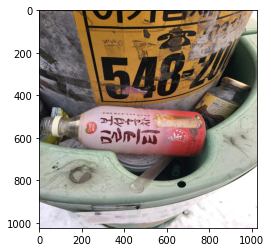

In [17]:
image = Image.open(image_path)
print(type(image))
plt.imshow(image)

<class 'numpy.ndarray'>
(1024, 1024, 3)


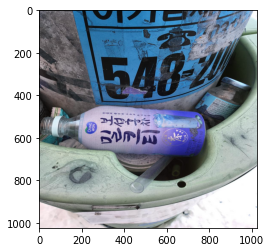

In [18]:
image = cv2.imread(str(image_path))
print(type(image))
print(image.shape)
plt.imshow(image / 255)

3) annotation 정보 갖고 오기

In [19]:
ann_ids = coco.getAnnIds(imgIds=image_info['id'])
anns = coco.loadAnns(ann_ids)
print(ann_ids)
print(anns)

[1, 2, 3, 4, 5, 6, 7, 8]
[{'image_id': 1, 'category_id': 3, 'area': 10402.56, 'bbox': [0.0, 407.4, 57.6, 180.6], 'iscrowd': 0, 'id': 1}, {'image_id': 1, 'category_id': 7, 'area': 26259.36, 'bbox': [0.0, 455.6, 144.6, 181.6], 'iscrowd': 0, 'id': 2}, {'image_id': 1, 'category_id': 4, 'area': 69096.17, 'bbox': [722.3, 313.4, 274.3, 251.9], 'iscrowd': 0, 'id': 3}, {'image_id': 1, 'category_id': 5, 'area': 24164.58, 'bbox': [353.2, 671.0, 233.7, 103.4], 'iscrowd': 0, 'id': 4}, {'image_id': 1, 'category_id': 5, 'area': 188324.4, 'bbox': [3.7, 448.5, 778.2, 242.0], 'iscrowd': 0, 'id': 5}, {'image_id': 1, 'category_id': 0, 'area': 38908.72, 'bbox': [425.3, 681.9, 216.4, 179.8], 'iscrowd': 0, 'id': 6}, {'image_id': 1, 'category_id': 7, 'area': 7391.52, 'bbox': [92.4, 601.7, 139.2, 53.1], 'iscrowd': 0, 'id': 7}, {'image_id': 1, 'category_id': 0, 'area': 6857.76, 'bbox': [622.4, 686.5, 72.8, 94.2], 'iscrowd': 0, 'id': 8}]


In [20]:
boxes = np.array([x['bbox'] for x in anns])
print(boxes)
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
print()
print(boxes)

[[  0.  407.4  57.6 180.6]
 [  0.  455.6 144.6 181.6]
 [722.3 313.4 274.3 251.9]
 [353.2 671.  233.7 103.4]
 [  3.7 448.5 778.2 242. ]
 [425.3 681.9 216.4 179.8]
 [ 92.4 601.7 139.2  53.1]
 [622.4 686.5  72.8  94.2]]

[[  0.  407.4  57.6 588. ]
 [  0.  455.6 144.6 637.2]
 [722.3 313.4 996.6 565.3]
 [353.2 671.  586.9 774.4]
 [  3.7 448.5 781.9 690.5]
 [425.3 681.9 641.7 861.7]
 [ 92.4 601.7 231.6 654.8]
 [622.4 686.5 695.2 780.7]]


In [21]:
labels = np.array([x['category_id'] for x in anns])
labels1 = torch.tensor(labels, dtype=torch.int64)
labels2 = torch.as_tensor(labels, dtype=torch.int64)
print(labels1)
print(labels2)

tensor([3, 7, 4, 5, 5, 0, 7, 0])
tensor([3, 7, 4, 5, 5, 0, 7, 0])


In [22]:
boxes_copy = boxes.copy()
print(boxes)
boxes_copy[0][1] = 1
print(boxes_copy)

[[  0.  407.4  57.6 588. ]
 [  0.  455.6 144.6 637.2]
 [722.3 313.4 996.6 565.3]
 [353.2 671.  586.9 774.4]
 [  3.7 448.5 781.9 690.5]
 [425.3 681.9 641.7 861.7]
 [ 92.4 601.7 231.6 654.8]
 [622.4 686.5 695.2 780.7]]
[[  0.    1.   57.6 588. ]
 [  0.  455.6 144.6 637.2]
 [722.3 313.4 996.6 565.3]
 [353.2 671.  586.9 774.4]
 [  3.7 448.5 781.9 690.5]
 [425.3 681.9 641.7 861.7]
 [ 92.4 601.7 231.6 654.8]
 [622.4 686.5 695.2 780.7]]


### transform

In [23]:
sample = {
    'image': image,
    'bboxes': boxes,
    'labels': labels
}

In [24]:
trans = A.Compose([
        A.Resize(height = 224, width = 224),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [25]:
trans(**sample)

{'image': tensor([[[253, 255, 255,  ..., 100, 123,  79],
          [254, 254, 255,  ..., 126,  98, 109],
          [255, 255, 255,  ..., 109, 100, 115],
          ...,
          [251, 253, 252,  ..., 239, 239, 239],
          [252, 255, 254,  ..., 238, 239, 239],
          [251, 254, 255,  ..., 238, 237, 237]],
 
         [[253, 255, 255,  ...,  99, 122,  78],
          [254, 254, 255,  ..., 126,  97, 108],
          [255, 255, 255,  ..., 108,  99, 114],
          ...,
          [251, 253, 252,  ..., 225, 225, 225],
          [249, 252, 251,  ..., 224, 225, 225],
          [244, 247, 250,  ..., 224, 223, 223]],
 
         [[253, 255, 255,  ..., 109, 131,  88],
          [254, 254, 255,  ..., 135, 107, 118],
          [255, 255, 255,  ..., 118, 109, 124],
          ...,
          [251, 253, 252,  ..., 227, 227, 227],
          [251, 254, 253,  ..., 226, 227, 227],
          [250, 253, 255,  ..., 226, 225, 225]]], dtype=torch.uint8),
 'bboxes': [(211.4, 89.11874999999999, 224.0, 128.625)

## Experiment 2(Dataset test)

In [26]:
ds = CustomDataset(annotation=annotation, data_dir=data_dir, transforms=get_train_transform())
ds[5]

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


(tensor([[[0.6745, 0.6382, 0.6196,  ..., 0.1912, 0.1843, 0.1745],
          [0.6294, 0.6353, 0.6020,  ..., 0.1951, 0.1529, 0.1304],
          [0.6088, 0.6275, 0.6245,  ..., 0.2235, 0.1873, 0.2069],
          ...,
          [0.8627, 0.8627, 0.8539,  ..., 0.1353, 0.1333, 0.1353],
          [0.8716, 0.8725, 0.8667,  ..., 0.1471, 0.1412, 0.1353],
          [0.8706, 0.8745, 0.8725,  ..., 0.1500, 0.1422, 0.1402]],
 
         [[0.6784, 0.6422, 0.6235,  ..., 0.2069, 0.2000, 0.1902],
          [0.6333, 0.6392, 0.6059,  ..., 0.2108, 0.1686, 0.1461],
          [0.6127, 0.6314, 0.6284,  ..., 0.2392, 0.2029, 0.2225],
          ...,
          [0.8784, 0.8784, 0.8696,  ..., 0.3078, 0.3108, 0.3118],
          [0.8873, 0.8882, 0.8824,  ..., 0.3196, 0.3176, 0.3196],
          [0.8863, 0.8902, 0.8882,  ..., 0.3284, 0.3265, 0.3206]],
 
         [[0.6941, 0.6578, 0.6392,  ..., 0.2108, 0.2039, 0.1941],
          [0.6412, 0.6471, 0.6137,  ..., 0.2147, 0.1725, 0.1500],
          [0.6206, 0.6392, 0.6363,  ...,